## Download dataset from Kaggle website

In [ ]:
from google.colab import files

In [ ]:
# Note - need to download json from Kaggle in order to use their API for competition data download
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jacobbrodriguez","key":"84c5f64ae87c9aa2ebbc646c5ac8db1e"}'}

In [ ]:
!mkdir /root/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c conways-reverse-game-of-life-2020

  0% 0.00/281k [00:00<?, ?B/s]
100% 281k/281k [00:00<00:00, 41.6MB/s]
100% 4.06M/4.06M [00:01<00:00, 4.06MB/s]

 63% 5.00M/7.91M [00:02<00:01, 2.60MB/s]
100% 7.91M/7.91M [00:02<00:00, 4.01MB/s]


In [ ]:
! unzip sample_submission.csv.zip
! unzip test.csv.zip
! unzip train.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


## Import datasets and perform preprocessing

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_df.head()

,id,delta,stop_0,stop_1,stop_2,stop_3,stop_4,stop_5,stop_6,stop_7,stop_8,stop_9,stop_10,stop_11,stop_12,stop_13,stop_14,stop_15,stop_16,stop_17,stop_18,stop_19,stop_20,stop_21,stop_22,stop_23,stop_24,stop_25,stop_26,stop_27,stop_28,stop_29,stop_30,stop_31,stop_32,stop_33,stop_34,stop_35,stop_36,stop_37,...,stop_585,stop_586,stop_587,stop_588,stop_589,stop_590,stop_591,stop_592,stop_593,stop_594,stop_595,stop_596,stop_597,stop_598,stop_599,stop_600,stop_601,stop_602,stop_603,stop_604,stop_605,stop_606,stop_607,stop_608,stop_609,stop_610,stop_611,stop_612,stop_613,stop_614,stop_615,stop_616,stop_617,stop_618,stop_619,stop_620,stop_621,stop_622,stop_623,stop_624
0,50000,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
1,50001,5,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0
2,50002,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,...,0,0,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0
3,50003,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,50004,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Saving ID column of test data for Kaggle submission - required in final output
save_id = test_df["id"]
save_id

0        50000
1        50001
2        50002
3        50003
4        50004
         ...  
49995    99995
49996    99996
49997    99997
49998    99998
49999    99999
Name: id, Length: 50000, dtype: int64

### Drop the id column

In [ ]:
train_df.drop(columns={"id"}, inplace=True)
test_df.drop(columns={"id"}, inplace=True)
train_df.head()

,delta,start_0,start_1,start_2,start_3,start_4,start_5,start_6,start_7,start_8,start_9,start_10,start_11,start_12,start_13,start_14,start_15,start_16,start_17,start_18,start_19,start_20,start_21,start_22,start_23,start_24,start_25,start_26,start_27,start_28,start_29,start_30,start_31,start_32,start_33,start_34,start_35,start_36,start_37,start_38,...,stop_585,stop_586,stop_587,stop_588,stop_589,stop_590,stop_591,stop_592,stop_593,stop_594,stop_595,stop_596,stop_597,stop_598,stop_599,stop_600,stop_601,stop_602,stop_603,stop_604,stop_605,stop_606,stop_607,stop_608,stop_609,stop_610,stop_611,stop_612,stop_613,stop_614,stop_615,stop_616,stop_617,stop_618,stop_619,stop_620,stop_621,stop_622,stop_623,stop_624
0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


#### Note that the *delta* column refers to the number of steps between the Start and Stop boards

In [ ]:
train_df['delta'].describe()
# Delta only goes until 5 and can be 1 - 5

count    50000.000000
mean         2.992540
std          1.415869
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: delta, dtype: float64

## Visualizing a start and end board with the correct 25x25 formatting (Yellow Active)

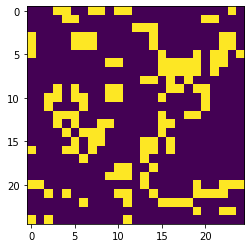

In [ ]:
import matplotlib.pyplot as plt
# Getting the end board and plotting
single = train_df.iloc[25,626:]
single_re = single.values.reshape(25,25)
fig, ax = plt.subplots()
plt.imshow(single_re)
plt.show()

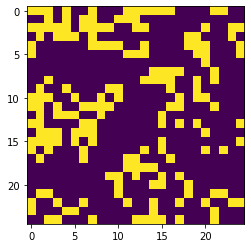

In [ ]:
# Doing the same but for the instance's start board
single = train_df.iloc[25,1:626]
single_re = single.values.reshape(25,25)
fig, ax = plt.subplots()
plt.imshow(single_re)
plt.show()

## Preprocess into 25x25 arrays for CNN model

In [ ]:
import numpy as np
import tensorflow as tf
# Split into start and stop based on string column name
train_start = train_df.loc[:, train_df.columns.str.startswith('start')]
train_stop = train_df.loc[:, train_df.columns.str.startswith('stop')]

test_stop = train_df.loc[:, train_df.columns.str.startswith('stop')]
# Convert to numpy array and reshape to 25x25
start_array = np.asarray(train_start).reshape(train_start.shape[0],25,25)
stop_array = np.asarray(train_stop).reshape(train_stop.shape[0],25,25)

stop_array_test = np.asarray(test_stop).reshape(test_stop.shape[0],25,25)

# Get time steps
time_step = train_df['delta']
time_step_test = test_df['delta']


## Model creation

#### First attempt will be to exclude the delta time-step feature and see performance

In [43]:
# Split into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(stop_array, start_array, test_size = 0.2, shuffle=True, random_state=42)

### Keras model with CNN layers

In [ ]:
# Importing needed keras libraries
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU 
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPool1D, concatenate
from keras.models import Model
import keras
from keras import initializers, regularizers, constraints, optimizers, layers, Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD

In [ ]:
X_train.shape

(40000, 25, 25)

In [ ]:
# Trying sequential model - did not work with given data
'''
model = Sequential()
model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(1,1,X_train.shape[1])))
model.add(layers.MaxPooling1D())
model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(1,1,X_train.shape[1])))
model.add(layers.MaxPooling1D())
model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(1,1,X_train.shape[1])))
model.add(layers.MaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(625))
'''
# define the model - again this model did not work as well
'''
model = Sequential()
model.add(Dense(20, input_dim=626, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(625))
model.compile(loss='mae', optimizer='adam', metrics = ['accuracy'])
'''

inputShape = (25,25,1)
inputs = Input(inputShape)

c1 = layers.Conv2D(32, (3,3), activation='elu', padding='same')(inputs)
c2 = layers.Conv2D(64, (3,3), activation='elu', padding='same')(c1)
c3 = layers.Conv2D(128, (5,5), activation='elu', padding='same')(c2)
c4 = layers.Conv2D(64, (3,3), activation='elu', padding='same')(c3)
c5 = layers.Conv2D(32, (3,3), activation='elu', padding='same')(c4) # 4 layers
c6 = layers.Conv2D(1, (1,1), activation='sigmoid')(c5)

model = Model(inputs=[inputs], outputs=c6)


model.compile(loss ="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])
model.summary()
# Credit to: https://www.kaggle.com/robintwhite/iterative-cnn-in-tf-keras

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 25, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        73792     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 1)        

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=5)

Epoch 1/5
313/313 [==============================] - 1044s 3s/step - loss: 11.7361 - accuracy: 0.8456
Epoch 2/5
313/313 [==============================] - 1043s 3s/step - loss: 11.7265 - accuracy: 0.8478
Epoch 3/5
313/313 [==============================] - 1045s 3s/step - loss: 11.7165 - accuracy: 0.8485
Epoch 4/5
313/313 [==============================] - 1045s 3s/step - loss: 11.7085 - accuracy: 0.8490
Epoch 5/5
313/313 [==============================] - 1047s 3s/step - loss: 11.7012 - accuracy: 0.8492


In [ ]:
# Save model
#model.save("No_delta.h5")
from keras.models import load_model
model = load_model('No_delta.h5')

In [ ]:
# Run predictions
y_pred = model.predict(X_test)

In [ ]:
# Convert to binary output
preds = tf.cast(tf.where(y_pred>0.5,1,0), tf.uint32)

In [ ]:
# Reshaping for competition output
preds_numpy = preds.numpy()
preds_reshape_train = preds_numpy.reshape(-1, 625)

In [ ]:
# Checking accuracy of testing predictions
from sklearn.metrics import accuracy_score
y_test_reshape = y_test.reshape(-1, 625)
running_accuracy = 0
for actual, predict in zip(y_test_reshape, preds_reshape):
  running_accuracy += accuracy_score(actual, predict)
total_accuracy = running_accuracy/y_test_reshape.shape[0]
print("Total accuracy of testing set:\t", total_accuracy)

Total accuracy of testing set:	 0.8482953599999986


In [ ]:
# Getting feature names for start columns

start_features = [f for f in train_df.columns if "start" in f]
# Putting predicted output into required form for competition
predicted = pd.DataFrame(preds_reshape_train, columns=start_features, dtype=int)
predicted.head()

,start_0,start_1,start_2,start_3,start_4,start_5,start_6,start_7,start_8,start_9,start_10,start_11,start_12,start_13,start_14,start_15,start_16,start_17,start_18,start_19,start_20,start_21,start_22,start_23,start_24,start_25,start_26,start_27,start_28,start_29,start_30,start_31,start_32,start_33,start_34,start_35,start_36,start_37,start_38,start_39,...,start_585,start_586,start_587,start_588,start_589,start_590,start_591,start_592,start_593,start_594,start_595,start_596,start_597,start_598,start_599,start_600,start_601,start_602,start_603,start_604,start_605,start_606,start_607,start_608,start_609,start_610,start_611,start_612,start_613,start_614,start_615,start_616,start_617,start_618,start_619,start_620,start_621,start_622,start_623,start_624
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Actual Board')

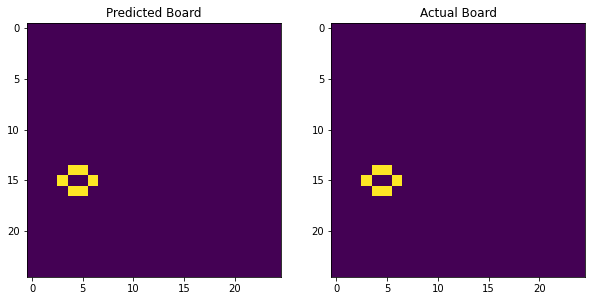

In [ ]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(preds_reshape[1].reshape(25,25))
ax[0].set_title("Predicted Board")

ax[1].imshow(y_test[1])
ax[1].set_title("Actual Board")

### Predictions for Kaggle

In [ ]:
# Run predictions
y_pred = model.predict(stop_array_test)

In [ ]:
# Convert to binary output
preds = tf.cast(tf.where(y_pred>0.5,1,0), tf.uint32)

In [ ]:
# Reshaping for competition output
preds_numpy = preds.numpy()
preds_reshape = preds_numpy.reshape(-1, 625)

In [ ]:
start_features = [f for f in train_df.columns if "start" in f]
# Putting predicted output into required form for competition
predicted = pd.DataFrame(preds_reshape, columns=start_features, dtype=int)
predicted.insert(0,"id", save_id)
predicted.head()

,id,start_0,start_1,start_2,start_3,start_4,start_5,start_6,start_7,start_8,start_9,start_10,start_11,start_12,start_13,start_14,start_15,start_16,start_17,start_18,start_19,start_20,start_21,start_22,start_23,start_24,start_25,start_26,start_27,start_28,start_29,start_30,start_31,start_32,start_33,start_34,start_35,start_36,start_37,start_38,...,start_585,start_586,start_587,start_588,start_589,start_590,start_591,start_592,start_593,start_594,start_595,start_596,start_597,start_598,start_599,start_600,start_601,start_602,start_603,start_604,start_605,start_606,start_607,start_608,start_609,start_610,start_611,start_612,start_613,start_614,start_615,start_616,start_617,start_618,start_619,start_620,start_621,start_622,start_623,start_624
0,50000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,50001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,50002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,50003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50004,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0


In [ ]:
np.count_nonzero(preds_reshape)

1069744

In [ ]:
id = pd.DataFrame(range(50000,60000), columns={"id"})

In [ ]:
predicted.insert(0,"id", pd.DataFrame(range(50000,60000)))

In [ ]:
predicted

,id,start_0,start_1,start_2,start_3,start_4,start_5,start_6,start_7,start_8,start_9,start_10,start_11,start_12,start_13,start_14,start_15,start_16,start_17,start_18,start_19,start_20,start_21,start_22,start_23,start_24,start_25,start_26,start_27,start_28,start_29,start_30,start_31,start_32,start_33,start_34,start_35,start_36,start_37,start_38,...,start_585,start_586,start_587,start_588,start_589,start_590,start_591,start_592,start_593,start_594,start_595,start_596,start_597,start_598,start_599,start_600,start_601,start_602,start_603,start_604,start_605,start_606,start_607,start_608,start_609,start_610,start_611,start_612,start_613,start_614,start_615,start_616,start_617,start_618,start_619,start_620,start_621,start_622,start_623,start_624
0,50000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,50001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,50002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,50003,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,50004,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,59995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9996,59996,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,59997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9998,59998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Multi-model approach (One for each delta type)

#### Create each of the 5 models

In [ ]:
inputShape = (25,25,1)
inputs = Input(inputShape)

c1 = layers.Conv2D(32, (3,3), activation='elu', padding='same')(inputs)
c2 = layers.Conv2D(64, (3,3), activation='elu', padding='same')(c1)
c3 = layers.Conv2D(128, (5,5), activation='elu', padding='same')(c2)
c4 = layers.Conv2D(64, (3,3), activation='elu', padding='same')(c3)
c5 = layers.Conv2D(32, (3,3), activation='elu', padding='same')(c4) # 4 layers
c6 = layers.Conv2D(1, (1,1), activation='sigmoid')(c5)

model_1 = Model(inputs=[inputs], outputs=c6)
model_1.compile(loss ="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])

model_2 = Model(inputs=[inputs], outputs=c6)
model_2.compile(loss ="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])

model_3 = Model(inputs=[inputs], outputs=c6)
model_3.compile(loss ="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])

model_4 = Model(inputs=[inputs], outputs=c6)
model_4.compile(loss ="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])

model_5 = Model(inputs=[inputs], outputs=c6)
model_5.compile(loss ="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])



In [ ]:
for delta, start, stop in zip(time_step, start_array, stop_array):
  if delta == 1:
    model_1.fit(stop.reshape(-1,25,25), start.reshape(-1,25,25), epochs=5, verbose=0)
  if delta == 2:
    model_2.fit(stop.reshape(-1,25,25), start.reshape(-1,25,25), epochs=5, verbose=0)
  if delta == 3:
    model_3.fit(stop.reshape(-1,25,25), start.reshape(-1,25,25), epochs=5, verbose=0)
  if delta == 4:
    model_4.fit(stop.reshape(-1,25,25), start.reshape(-1,25,25), epochs=5, verbose=0)
  if delta == 5:
    model_5.fit(stop.reshape(-1,25,25), start.reshape(-1,25,25), epochs=5, verbose=0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
#model_1.save("model_1.h5")
#model_2.save("model_2.h5")
#model_3.save("model_3.h5")
#model_4.save("model_4.h5")
#model_5.save("model_5.h5")

### Load all models and get test outputs

In [ ]:
from keras.models import load_model
model_1 = load_model('model_1.h5')
model_2 = load_model('model_2.h5')
model_3 = load_model('model_3.h5')
model_4 = load_model('model_4.h5')
model_5 = load_model('model_5.h5')

In [ ]:
time = 0
# Getting feature names for start columns
start_features = [f for f in train_df.columns if "start" in f]
outFrame = pd.DataFrame(columns=start_features, dtype=int)
for delta, stop in zip(time_step_test, stop_array_test):
  if delta == 1:
    y_pred = model_1.predict(stop.reshape(-1,25,25))
  elif delta == 2:
    y_pred = model_2.predict(stop.reshape(-1,25,25))
  elif delta == 3:
    y_pred = model_3.predict(stop.reshape(-1,25,25))
  elif delta == 4:
    y_pred = model_4.predict(stop.reshape(-1,25,25))
  elif delta == 5:
    y_pred = model_5.predict(stop.reshape(-1,25,25))

  preds = tf.cast(tf.where(y_pred>0.5,1,0), tf.uint32)
  preds_numpy = preds.numpy()
  preds_reshape_test = preds_numpy.reshape(-1, 625)
  tempFrame = pd.DataFrame(preds_reshape_test, columns=start_features, dtype=int)
  print(tempFrame)
  outFrame = outFrame.append(tempFrame)
  if time == 7:
    break
  time += 1
  

### Model does not give expected output
#### Due to time constraints we have no time left to debug since training took about 4 hours

### Will instead revisit original model but add more layers

In [44]:
inputShape = (25,25,1)
inputs = Input(inputShape)

c1 = layers.Conv2D(32, (3,3), activation='elu', padding='same')(inputs)
c2 = layers.Conv2D(64, (3,3), activation='elu', padding='same')(c1)
c3 = layers.Conv2D(64, (3,3), activation='elu', padding='same')(c2)
c4 = layers.Conv2D(128, (5,5), activation='elu', padding='same')(c3)
c5 = layers.Conv2D(128, (5,5), activation='elu', padding='same')(c4)
c6 = layers.Conv2D(64, (3,3), activation='elu', padding='same')(c5)
c7 = layers.Conv2D(64, (3,3), activation='elu', padding='same')(c6)
c8 = layers.Conv2D(32, (3,3), activation='elu', padding='same')(c7) # 7 layers
c9 = layers.Conv2D(1, (1,1), activation='sigmoid')(c8)

model = Model(inputs=[inputs], outputs=c9)


model.compile(loss ="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 25, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 128)       409728    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 64)       

#### Note that actual training and scoring for this model took place on Kaggle through their notebook entries.

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=5)

## Random Forest

In [ ]:
from scipy import signal
from scipy.signal import convolve2d

# Return an neighbor matrix of the 25x25x grid (each index will have the number of neighboring alive cells to that cell)
def neighbors_array(X):
    
    # Neighbors grid to pass into convolve function (everything surrounding center checked as neighbor)
    neighbours = np.array([[1,1,1],[1,0,1],[1,1,1]], dtype=np.int8)
    
    # Count number of neighbors of each cell, don't wrap around
    res = np.array([[signal.convolve2d(X[n], neighbours, boundary='fill', mode='same')] 
        for n in range(len(X))])

    # Flatten 25x25 array to 625 vector
    res = res.reshape(res.shape[0], -1)
    return res

In [ ]:
# Convert the training features to neighbors
neighbors = neighbors_array(start_array)
# Flatten 25x25 to 625
stop = stop_array.reshape(stop_array.shape[0], -1)
print(f'neighbors.shape: {neighbors.shape}, stop.shape: {stop.shape}')

# Split into training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(neighbors, stop, test_size = 0.5, shuffle=True, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# RF Classifier with a max depth of 20
rf_clf = RandomForestClassifier(max_depth=20, n_jobs=-1,verbose=0,)
rf_clf.fit(X_train, y_train)
y_val_pred = rf_clf.predict(X_val)

In [ ]:
def accuracy( Y_actual, Y_pred ):
    # total matching values/total values
    return np.mean( np.count_nonzero( Y_actual == Y_pred, axis=1 ) / 625 )

print('y_val accuracy:', accuracy(y_val, y_val_pred))
print('number of 1s predicted:', np.count_nonzero(y_val_pred))

Although the accuracy score is 0.853, the predicted dataset was entirely 0s. Random forest is not well suited to learning the reverse game of life, due to how sparse the vectors are. Passing in the original 25x25 active/dead values and the neighbors vector both fail to accurately learn the problem.

## Bidirectional LSTM RNN

In [ ]:
model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape=(625,1)),
# Bidirectional LSTM layers, returning last output
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48,return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48,return_sequences=True)),
tf.keras.layers.Dense(1, activation='sigmoid')
])

# Binary crossentropy for binary classification, evaluating accuracy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
start = start_array.reshape(stop_array.shape[0], -1)
stop = stop_array.reshape(stop_array.shape[0], -1)
X_train, X_val, y_train, y_val = train_test_split(start, stop, test_size = 0.5, shuffle=True, random_state=42)
# Reshape data for the input layer
X_train_RNN = np.expand_dims(X_train,axis=2)
X_val_RNN = np.expand_dims(X_val,axis=2)

# Fit on training data
model.fit(X_train_RNN, y_train, epochs=4, batch_size=128)
# Predict validation data
y_val_pred = model.predict(X_val_RNN)
# Change sigmoid output to 0s and 1s, and reformat
result = np.squeeze(np.where(y_val_pred>0.5,1,0), axis=(2,))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

print('y_val accuracy:', accuracy(y_val, result))
print('f1_score:', f1_score(y_val.flatten(), result.flatten(), average='macro'))
print('number of 1s predicted:', np.count_nonzero(result))
print('number of 1s actual:', np.count_nonzero(y_val))

cm = confusion_matrix(y_val.flatten(), result.flatten())
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

## Bidirectional LSTM RNN, split into 5 models based on delta

In [ ]:
def RNN_model():
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(625,1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48,return_sequences=True)),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'mae'])
    
    return model

# Create 5 Models, one fitted for each delta value from 1 through 5

model_RNN_1 = RNN_model()
model_RNN_2 = RNN_model()
model_RNN_3 = RNN_model()
model_RNN_4 = RNN_model()
model_RNN_5 = RNN_model()
models = [model_RNN_1, model_RNN_2, model_RNN_3, model_RNN_4, model_RNN_5]

In [ ]:
# Train each model on the subset of data with the specified delta value
for delta in range(1, 6):
    delta_df = train_df[train_df['delta'] == delta]
    delta_start = delta_df.loc[:, delta_df.columns.str.startswith('start')]
    delta_stop = delta_df.loc[:, delta_df.columns.str.startswith('stop')]
    start_arr = np.asarray(delta_start)
    stop_arr = np.asarray(delta_stop)
    X_train = np.expand_dims(start_arr,axis=2)
    print("Training on delta", delta)
    models[delta-1].fit(X_train, stop_arr, epochs=5, batch_size=128)

In [ ]:
# Prepare submission dataframe for output

submission_df = train_start.copy()
submission_df = submission_df.iloc[0:0]
columns_list = submission_df.columns
submission_df.insert(0, "id", [])
submission_df

In [ ]:
test_df = pd.read_csv("test.csv")

# Predict subsets of test using each model
for delta in range(1, 6):
    print("Predicting on delta", delta)
    # Get the list of indices with this delta value
    index_list = test_df.loc[test_df['delta'] == delta, 'id'].tolist()
    # Get the subset of test data with this delta value
    test_data = test_df[test_df.delta == delta].drop(columns={'id', 'delta'})
    test_arr = np.asarray(test_data)
    X_test = np.expand_dims(test_arr,axis=2)
    # Predict on the subset and reformat
    test_pred = models[delta-1].predict(X_test)
    test_result = np.squeeze(np.where(test_pred>0.5,1,0), axis=(2,))
    # Update the submission dataframe
    tmp_df = pd.DataFrame(test_result, columns=columns_list)
    tmp_df.insert(0, "id", index_list)
    submission_df = pd.concat([submission_df, tmp_df], axis=0,ignore_index=True)

In [ ]:
# Reformat dataframe and output
submission_df = submission_df.sort_values(by=['id']).reset_index(drop=True).astype(int)
submission_df.to_csv('./submission.csv', index=False)